In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader
import torch.optim as optim
import itertools
import numpy as np
from tqdm.autonotebook import tqdm

In [2]:
class Config: 
    train_batch_size=8 
    val_batch_size=8 
    num_res_cnn=3 
    num_rnn=5 
    input_features=128 

    #residual_cnn_params
    res_cnn_input_channels=32 
    res_cnn_output_channels=32 
    res_cnn_kernel_size=3 
    res_cnn_stride=1    
    res_cnn_padding=1 
    res_cnn_dropout_probability=0.1 
    
    #bi directional rnn params
    bi_rnn_input_size=512 
    bi_rnn_hidden_size=512 
    bi_rnn_num_layers=1 
    bi_rnn_dropout_probability=0.1 
    
    #final classifier block params
    cl_input_size=bi_rnn_input_size*2 
    cl_dropout_probability=0.1 
    cl_num_classes=29 
    
#     optimizatson
    device='cuda' if torch.cuda.is_available() else 'cpu'
    lr=1e-5
    epochs=2
    
    

In [3]:
# data
train_data=torchaudio.datasets.LIBRISPEECH('./',url='dev-clean',download=True) 
val_data=torchaudio.datasets.LIBRISPEECH('./',url='test-clean',download=True) 

In [4]:
train_transforms=nn.Sequential(
                                torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=Config.input_features),
                                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                                torchaudio.transforms.TimeMasking(time_mask_param=35)
                                )
# after the transformation what we get is (batch ,channel,feature,time)
val_transforms=nn.Sequential(
                                torchaudio.transforms.MelSpectrogram()
                            )




all_data=itertools.chain(train_data,val_data)
tensor_max_length=-1
label_max_length=-1
for instance in all_data:
    data_len=train_transforms(instance[0]).shape[-1]    
    label_len=len(instance[2])
    
    if data_len>tensor_max_length:
        tensor_max_length=data_len
    if label_len>label_max_length:
        label_max_length=label_len
        
    
tensor_max_length,label_max_length

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


(2797, 576)

In [5]:
alphas=["'",' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
nums=range(28)
alpha_to_num_dict={alphas[i]:nums[i] for i in range(len(alphas))}
num_to_alpha_dict={v:k for k,v in alpha_to_num_dict.items()}


def num_to_alpha(number:torch.tensor):
    return num_to_alpha_dict[number.item()] 

def alpha_to_num(alpha):
    return alpha_to_num_dict[alpha.lower()] 

In [6]:
class Dataloader:
    def __init__(self,data,transforms):
        self.data=data
        self.transforms=transforms
    
    def __getitem__(self,idx):
        single_audio,transcript=self.transforms(self.data[idx][0]),self.data[idx][2]
        single_audio_=torch.nn.functional.pad(single_audio,(0,tensor_max_length-single_audio.shape[2]),mode='constant',value=0)
        single_label=torch.tensor(list(map(alpha_to_num,transcript)),dtype=torch.long)
        
        return {
                'data':single_audio_.transpose(-1,-2),
                'label':torch.nn.functional.pad(single_label,(0,label_max_length-single_label.shape[-1]),mode='constant',value=0),
                'data_len': torch.tensor(single_audio.shape[2],dtype=torch.long),
                'label_len':torch.tensor(len(transcript),dtype=torch.long)
                }
        
    def __len__(self):
        return len(self.data)
    
    
Train_Loader=DataLoader(Dataloader(train_data,transforms=train_transforms),batch_size=Config.train_batch_size,shuffle=True)
Val_Loader=DataLoader(Dataloader(val_data,transforms=val_transforms),batch_size=Config.val_batch_size,shuffle=True)

In [7]:
def layernorm(x,input_features):
    Layer=nn.LayerNorm(input_features)
    Layer.to(Config.device)
    return Layer(x)

class ResidualCNN(nn.Module):
    def __init__(self,in_channels,out_channels,kernel,stride,padding,dropout_probability,input_features):
        super().__init__()
        self.input_features=input_features
        self.conv_1=nn.Conv2d(in_channels,out_channels,kernel,stride,padding)
        self.conv_2=nn.Conv2d(out_channels,out_channels,kernel,stride,padding)  
        self.drop_1=nn.Dropout(dropout_probability)
        self.drop_2=nn.Dropout(dropout_probability)
    
    def forward(self,batch):
        residue=batch
        batch=f.gelu(layernorm(batch,self.input_features))
        batch=self.drop_1(batch)
        batch=self.conv_1(batch)
        batch=f.gelu(layernorm(batch,self.input_features))
        batch=self.drop_2(batch)
        batch=self.conv_2(batch)
        return batch+residue
    
class BidirectionalGRU(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,dropout_probability):
        """
        input_size=n_features
        hidden_size= nom feature in the hidden state
        num_layers= how many rnns do you wanna stack
        """
        
        super().__init__()
        self.input_size=input_size
        self.bi_gru=nn.GRU(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True,bidirectional=True)
        self.drop=nn.Dropout(dropout_probability)
        
    def forward(self,batch):
        batch=f.gelu(layernorm(batch,self.input_size))
        batch=self.bi_gru(batch)
        batch=self.drop(batch[0] if type(batch)==tuple else batch)
        return batch
    
    
    
    
# model inspired from deep speech 2
class SpeechRecognitionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn=nn.Conv2d(in_channels=1,
                            out_channels=32,
                            kernel_size=3,
                            stride=1,
                            padding=1)
        
        self.linear=nn.Linear(Config.res_cnn_output_channels*Config.input_features,Config.bi_rnn_input_size) 
        
        self.res_cnn=nn.Sequential(*[ResidualCNN(in_channels=Config.res_cnn_input_channels,
                                                 out_channels=Config.res_cnn_output_channels,
                                                 kernel=Config.res_cnn_kernel_size,
                                                 stride=Config.res_cnn_stride,
                                                 padding=Config.res_cnn_padding,
                                                 dropout_probability=Config.res_cnn_dropout_probability,
                                                 input_features=Config.input_features) for _ in range(Config.num_res_cnn)])
        
        self.rnn_layers=nn.Sequential(*[BidirectionalGRU(input_size=Config.bi_rnn_input_size if i==0 else 2*Config.bi_rnn_input_size,
                                                         hidden_size=Config.bi_rnn_hidden_size,
                                                         num_layers=Config.bi_rnn_num_layers,
                                                         dropout_probability=Config.bi_rnn_dropout_probability) for i in range(Config.num_rnn)])
        self.classifier=nn.Sequential(
                                    nn.Linear(Config.cl_input_size,Config.cl_input_size//2),
                                    nn.GELU(),
                                    nn.Dropout(Config.cl_dropout_probability),
                                    nn.Linear(Config.cl_input_size//2,Config.cl_num_classes))
        
    def forward(self,batch):
        time_dim=batch.shape[2]
        batch_size=batch.shape[0]
        out=self.cnn(batch)
        out=self.res_cnn(out)
        out=out.view(batch_size,time_dim,Config.res_cnn_output_channels*Config.input_features) 
        out=self.linear(out)
        out=self.rnn_layers(out)
        out=self.classifier(out)
        return out

In [8]:
model=SpeechRecognitionModel()
model=model.to(Config.device)

In [9]:
optimizer=optim.AdamW(model.parameters(),lr=Config.lr)
scheduler=optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=Config.lr,
    steps_per_epoch=int(len(Train_Loader)),
    epochs=Config.epochs,
    anneal_strategy='linear')

criterion=nn.CTCLoss(blank=28).to(Config.device)

In [13]:
class Train:
    def __init__(self,optimizer,scheduler,model,criterion):
        self.optimizer=optimizer
        self.scheduler=scheduler
        self.model=model
        self.criterion=criterion
    
    def fit(self,train_loader):
        losses=[]
        for idx,batch in tqdm(enumerate(train_loader),desc='traning',total=len(train_loader)):
            train_x=batch['data'].to(Config.device)
            train_y=batch['label'].to(Config.device)
            train_x_len=batch['data_len'].to(Config.device)
            train_y_len=batch['label_len'].to(Config.device)
            out=self.model(train_x)
            out=f.log_softmax(out,dim=-1)
            out=out.transpose(0,1)
            loss=self.criterion(out,train_y,train_x_len,train_y_len)
            losses.append(loss.item())
            loss.backward()
            self.optimizer.zero_grad()
            self.optimizer.step()
            self.scheduler.step()
        return np.mean(losses)
                
            
    def predict(self,val_loader):
        losses=[]
        with torch.no_grad():
            for idx,batch in tqdm(enumerate(val_loader),desc='validating',total=len(val_loader)):
                val_x=batch['data'].to(Config.device)
                val_y=batch['label'].to(Config.device)
                val_x_len=batch['data_len'].to(Config.device)
                val_y_len=batch['label_len'].to(Config.device) 
                out=self.model(val_x)
                out=f.log_softmax(out,dim=-1)
                out=out.transpose(0,1)
                loss=self.criterion(out,val_y,val_x_len,val_y_len)
                losses.append(loss.item())
            return np.mean(losses)
        
train=Train(optimizer,scheduler,model,criterion)
train_losses=[]
val_losses=[]

for epoch in tqdm(range(Config.epochs),total=Config.epochs):
    train_loss=train.fit(Train_Loader)
    val_loss=train.predict(Val_Loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

  0%|          | 0/2 [00:00<?, ?it/s]

traning:   0%|          | 0/338 [00:00<?, ?it/s]

validating:   0%|          | 0/328 [00:00<?, ?it/s]

traning:   0%|          | 0/338 [00:00<?, ?it/s]

validating:   0%|          | 0/328 [00:00<?, ?it/s]

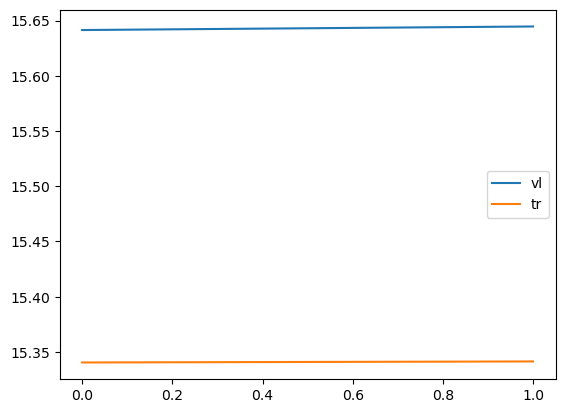

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(len(val_losses)),val_losses)
plt.plot(range(len(train_losses)),train_losses)
plt.legend(['vl','tr'])

### Read
- [CTCLoss](https://distill.pub/2017/ctc/?undefined)
- [Mel-Frequency](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html?undefined)
- [LibriSpeech](https://www.openslr.org/12/?undefined=&ref=news-tutorials-ai-research)